```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from utils.MovingAverager import *
from collections import defaultdict

# 讀檔

In [2]:
validation_traj = np.load(f'./window_5/all_user_match_data.npy', allow_pickle=True)

'cord_y', 'cord_x', 'times', 'acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t'

In [3]:
posture_data = defaultdict(list)

valid_data = validation_traj.item()
for user_name in valid_data.keys():
    for path_name in valid_data[user_name].keys():
        for posture_name in valid_data[user_name][path_name].keys():
            data = valid_data[user_name][path_name][posture_name]
            pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
            mag = data[:, [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]

            pos_mag = np.concatenate((pos, mag), axis=-1)
            posture_data[posture_name].append(pos_mag)

In [4]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [5]:
prep_valid_front_pocket_traj = split_traj(posture_data['front_pocket'])
prep_valid_horizontal_traj = split_traj(posture_data['horizontal'])
prep_valid_pocket_traj = split_traj(posture_data['pocket'])
prep_valid_swing_traj = split_traj(posture_data['swing'])
prep_valid_target_traj = split_traj(posture_data['target'])

In [6]:
# def expand_seq_features(seq):
#     ### neighbors
#     s_cord = seq[:, :, 0:2]
#     s_mag = seq[:, :, 2:5]
    
#     s_magT = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2) + np.power(s_mag[:, :, 2:3], 2))
#     s_magH = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2))  # magH
#     s_elevation_angle = np.arccos(s_magH / s_magT) / np.pi * 180  # angle
#     # n_azimuth_angle = 0
    
#     print(s_cord.shape, s_mag.shape, s_magT.shape, s_magH.shape, s_elevation_angle.shape)
#     s_new = np.concatenate([s_cord, s_mag, s_magT, s_magH, s_elevation_angle], axis=-1)
    
#     return s_new

In [7]:
# prep_valid_front_pocket_traj = expand_seq_features(prep_valid_front_pocket_traj)
# prep_valid_horizontal_traj = expand_seq_features(prep_valid_horizontal_traj)
# prep_valid_pocket_traj = expand_seq_features(prep_valid_pocket_traj)
# prep_valid_swing_traj = expand_seq_features(prep_valid_swing_traj)
# prep_valid_target_traj = expand_seq_features(prep_valid_target_traj)

In [8]:
prep_valid_front_pocket_traj.shape, prep_valid_horizontal_traj.shape, prep_valid_pocket_traj.shape, prep_valid_swing_traj.shape, prep_valid_target_traj.shape

((123, 20, 12), (123, 20, 12), (123, 20, 12), (123, 20, 12), (123, 20, 12))

In [9]:
datapoint_per_second = 20
duration = 2
seq_len = 10
classes = {0: 'target', 1: 'front_pocket', 2: 'horizontal', 3: 'pocket', 4: 'swing'}

# 建立dataloader

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [11]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [12]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [13]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)
    
    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    
#     print(source_total_mag.shape, target_total_mag.shape, pred_total_mag.shape)
#     print(source_total_mag[0])
#     print(target_total_mag[0])
#     print(pred_total_mag[0])
    
    smag_limitation_loss = torch.mean(torch.abs(pred_total_mag - source_total_mag))
    tmag_limitation_loss = torch.mean(torch.abs(pred_total_mag - target_total_mag))

    total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [15]:
# train
skip = len(prep_valid_front_pocket_traj) * 9 // 10
t_data = np.concatenate((prep_valid_front_pocket_traj[:skip], prep_valid_horizontal_traj[:skip], prep_valid_pocket_traj[:skip], prep_valid_swing_traj[:skip]))
t_target_data = np.concatenate((prep_valid_target_traj[:skip], prep_valid_target_traj[:skip], prep_valid_target_traj[:skip], prep_valid_target_traj[:skip]))

train_source_data = t_data
train_source_label = (np.arange(4) + 1).repeat(110)
train_target_data = t_target_data
train_target_label = np.zeros((110 * 4, ))
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# valid
v_data = np.concatenate((prep_valid_front_pocket_traj[skip:], prep_valid_horizontal_traj[skip:], prep_valid_pocket_traj[skip:], prep_valid_swing_traj[skip:]))
v_target_data = np.concatenate((prep_valid_target_traj[skip:], prep_valid_target_traj[skip:], prep_valid_target_traj[skip:], prep_valid_target_traj[skip:]))

valid_source_data = v_data
valid_source_label = (np.arange(4) + 1).repeat(13)
valid_target_data = v_target_data
valid_target_label = np.zeros((13 * 4, ))
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=64)

In [16]:
batch = next(iter(train_loader))

In [17]:
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [18]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 6),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = self.mag_last(pred_latent)
        
        return z_imu, pred_mag
        

In [20]:
model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [21]:
output = model(torch.empty(16, 10, 6).to(device), torch.empty(16, 10, 3).to(device))
output[0].shape, output[1].shape

(torch.Size([16, 10, 6]), torch.Size([16, 10, 3]))

In [22]:
from torchinfo import summary
summary(model, input_size=[(1, 10, 6), (1, 10, 3)])

Layer (type:depth-idx)                        Output Shape              Param #
NotSimpleTransformer                          [1, 10, 6]                --
├─Sequential: 1-1                             [1, 10, 64]               --
│    └─Linear: 2-1                            [1, 10, 32]               224
│    └─LeakyReLU: 2-2                         [1, 10, 32]               --
│    └─Linear: 2-3                            [1, 10, 64]               2,112
│    └─LeakyReLU: 2-4                         [1, 10, 64]               --
├─PositionalEncoding: 1-2                     [1, 10, 64]               --
│    └─Dropout: 2-5                           [1, 10, 64]               --
├─Sequential: 1-3                             [1, 10, 64]               --
│    └─Linear: 2-6                            [1, 10, 16]               64
│    └─LeakyReLU: 2-7                         [1, 10, 16]               --
│    └─Linear: 2-8                            [1, 10, 64]               1,088
│    └─LeakyR

In [23]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [24]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:8] + torch.randn_like(source_data[:, :, 2:8]) * 0.25
        source_mag = source_data[:, :, 8:11] + torch.randn_like(source_data[:, :, 8:11]) * 0.5
        source_total_mag = source_data[:, :, 11]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, 2:8]
        target_mag = target_data[:, :, 8:11]
        target_total_mag = target_data[:, :, 11]

        # generate mag
        z_imu, predict_mag = model(source_imu, source_mag)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [25]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:8]
            source_mag = source_data[:, :, 8:11]
            source_total_mag = source_data[:, :, 11]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 2:8]
            target_mag = target_data[:, :, 8:11]
            target_total_mag = target_data[:, :, 11]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

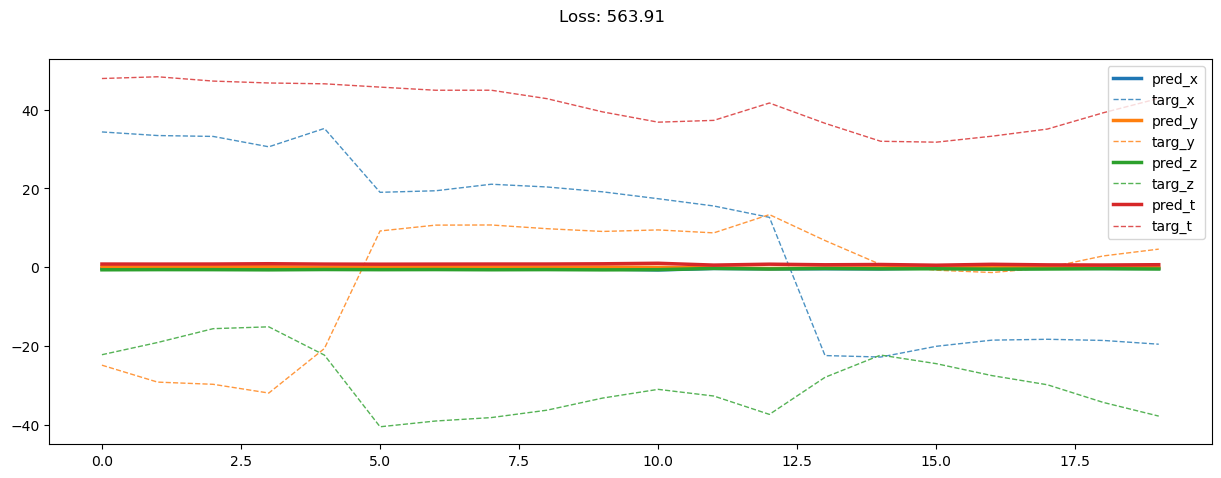

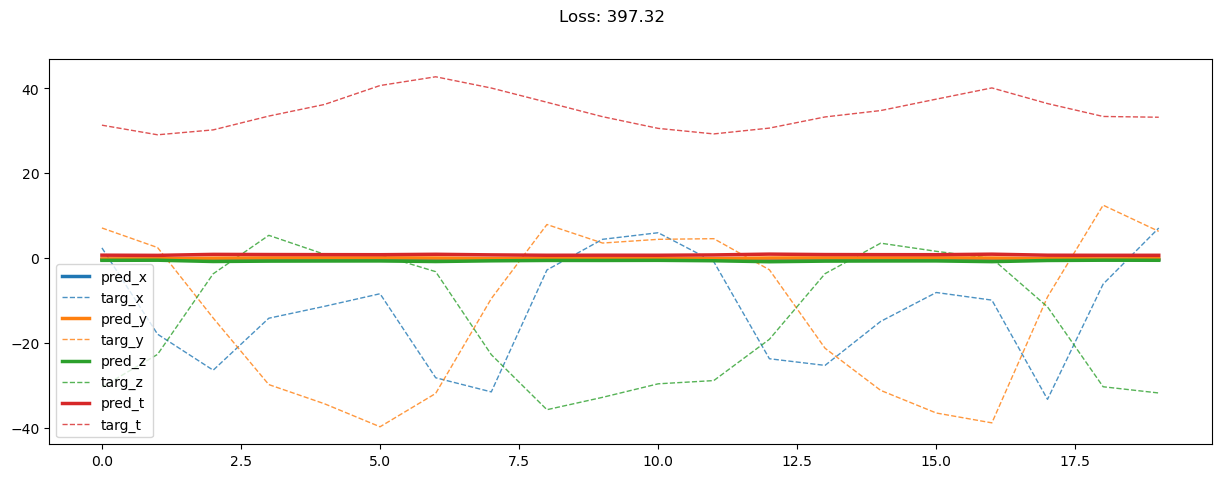

00500: train loss:  540.022, imu loss:  0.285, mag loss:  179.282, div loss:  348.852, slim:  11.979, tlim:  11.478
       valid loss:  769.965, imu loss:  0.520, mag loss:  425.117, div loss:  337.543, slim:  6.825, tlim:  6.771


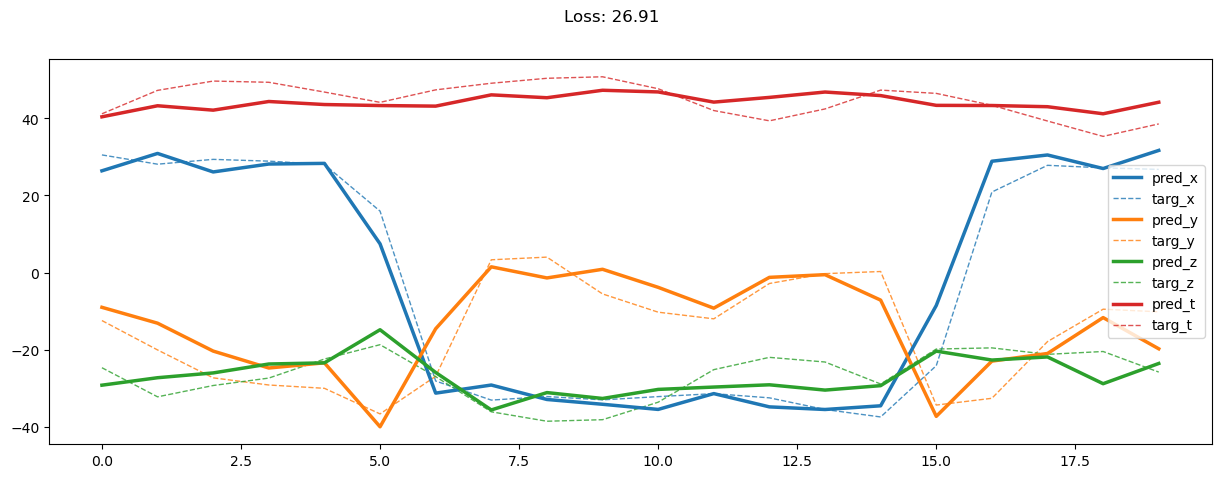

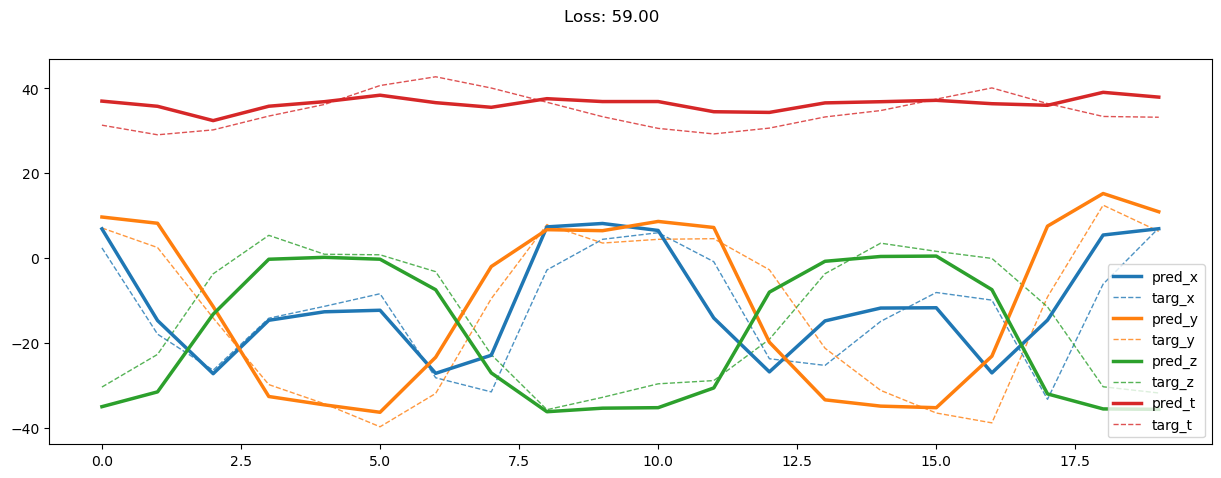

01000: train loss:  383.672, imu loss:  0.281, mag loss:  124.110, div loss:  252.333, slim:  7.879, tlim:  6.636
       valid loss:  764.364, imu loss:  0.520, mag loss:  389.713, div loss:  368.154, slim:  6.216, tlim:  5.896
01500: train loss:  314.274, imu loss:  0.280, mag loss:  103.606, div loss:  204.225, slim:  7.142, tlim:  5.838
       valid loss:  794.874, imu loss:  0.521, mag loss:  392.549, div loss:  394.885, slim:  6.768, tlim:  6.969


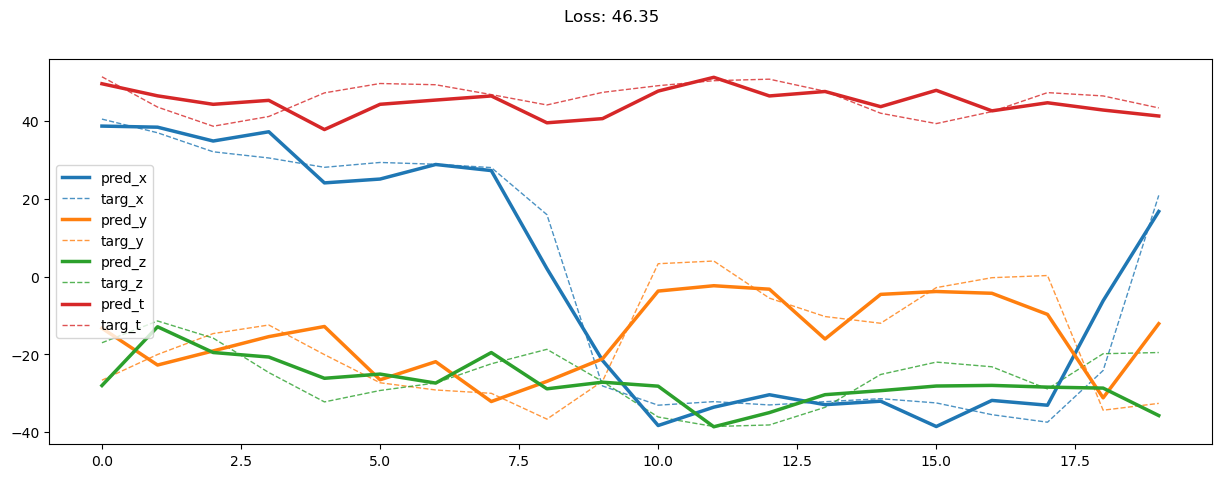

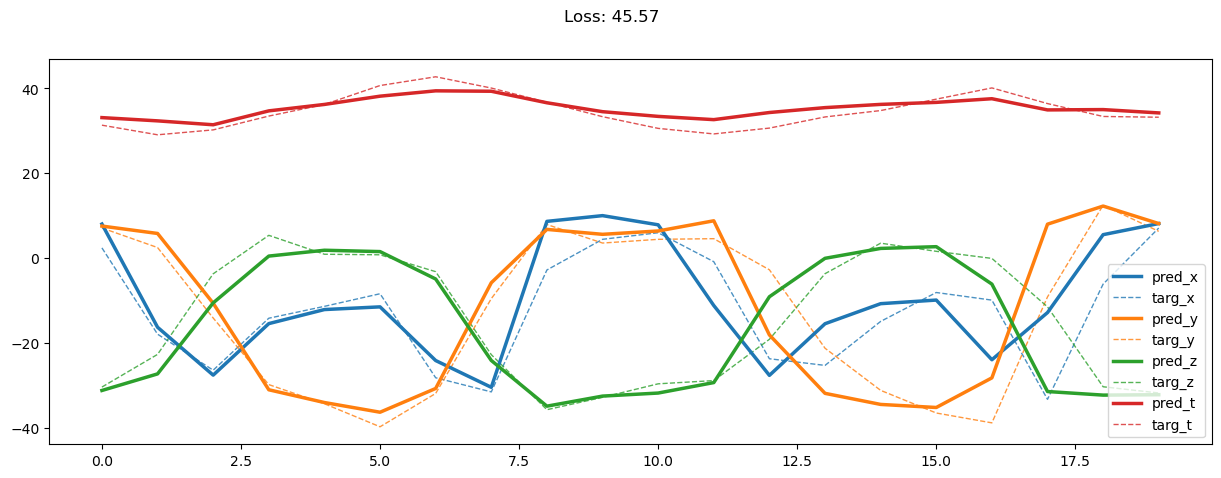

02000: train loss:  276.175, imu loss:  0.279, mag loss:  89.631, div loss:  180.624, slim:  6.617, tlim:  5.317
       valid loss:  818.062, imu loss:  0.525, mag loss:  400.862, div loss:  409.387, slim:  7.071, tlim:  7.361
02500: train loss:  240.291, imu loss:  0.278, mag loss:  78.867, div loss:  155.770, slim:  6.436, tlim:  5.024
       valid loss:  811.733, imu loss:  0.528, mag loss:  399.078, div loss:  404.930, slim:  7.022, tlim:  7.256


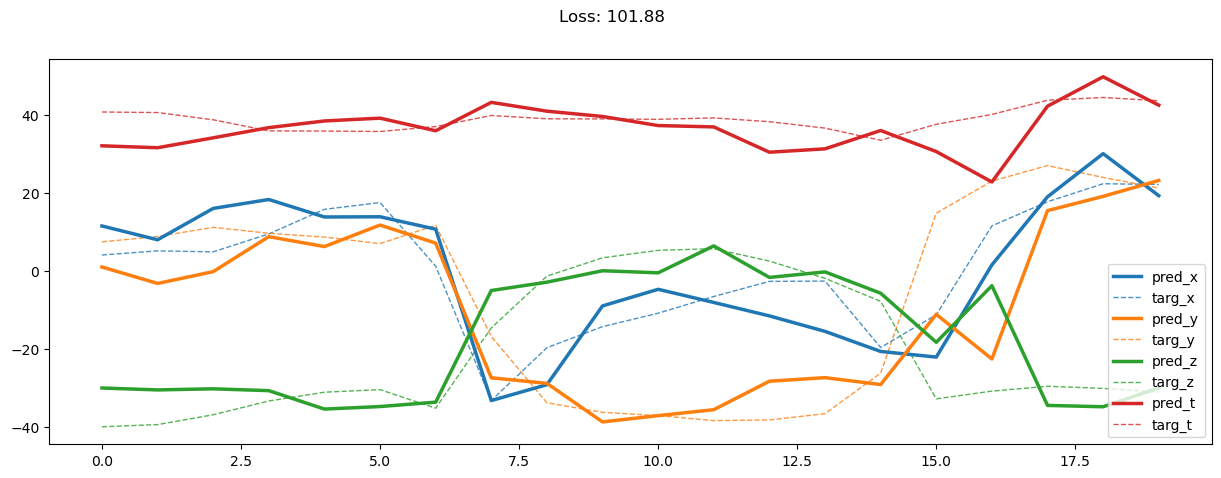

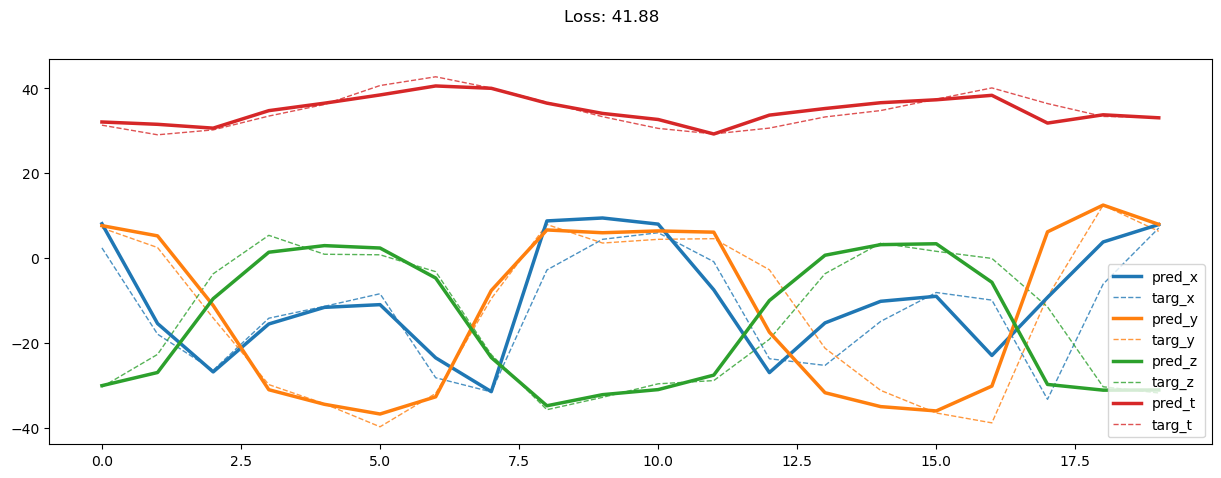

03000: train loss:  216.629, imu loss:  0.276, mag loss:  70.545, div loss:  140.715, slim:  6.265, tlim:  4.703
       valid loss:  792.258, imu loss:  0.528, mag loss:  387.631, div loss:  396.628, slim:  7.269, tlim:  7.539
03500: train loss:  197.220, imu loss:  0.274, mag loss:  64.281, div loss:  127.783, slim:  6.031, tlim:  4.499
       valid loss:  799.960, imu loss:  0.528, mag loss:  390.010, div loss:  402.146, slim:  7.087, tlim:  7.339


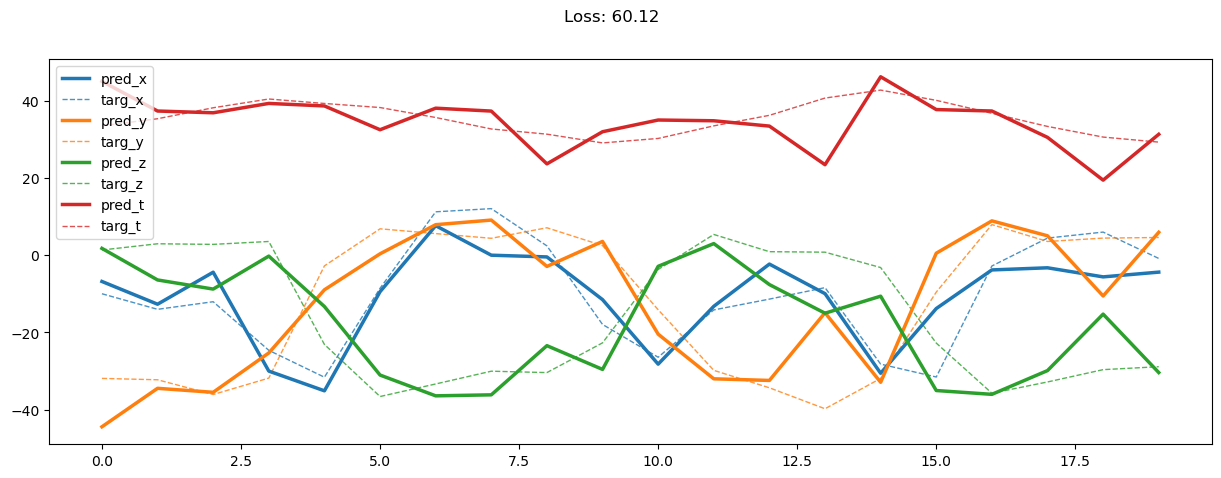

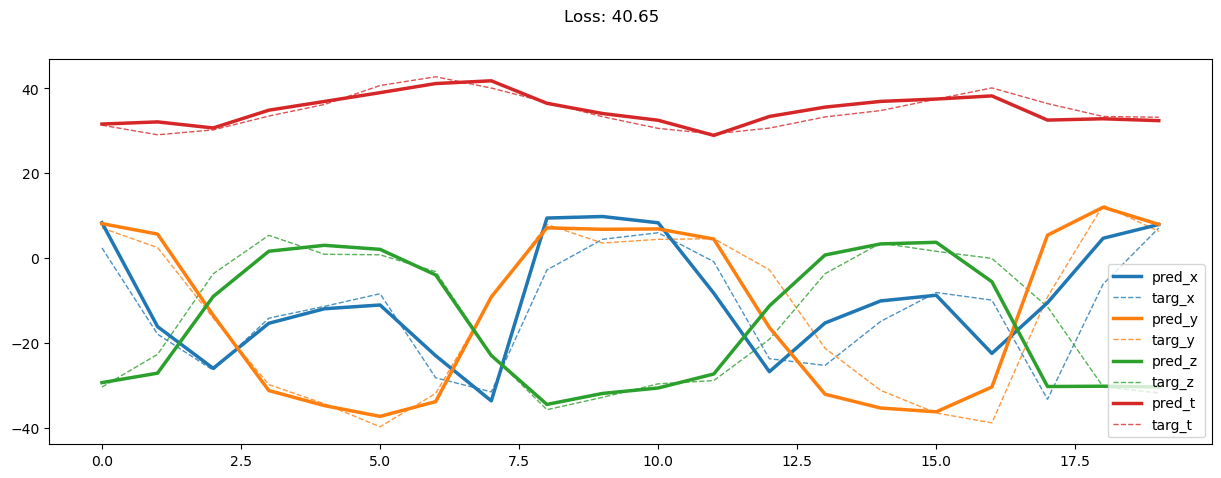

04000: train loss:  183.215, imu loss:  0.273, mag loss:  59.857, div loss:  118.496, slim:  5.835, tlim:  4.173
       valid loss:  800.865, imu loss:  0.530, mag loss:  389.635, div loss:  403.512, slim:  7.062, tlim:  7.229
04500: train loss:  158.652, imu loss:  0.273, mag loss:  51.510, div loss:  102.392, slim:  5.725, tlim:  4.060
       valid loss:  803.994, imu loss:  0.533, mag loss:  391.565, div loss:  405.054, slim:  6.772, tlim:  6.864


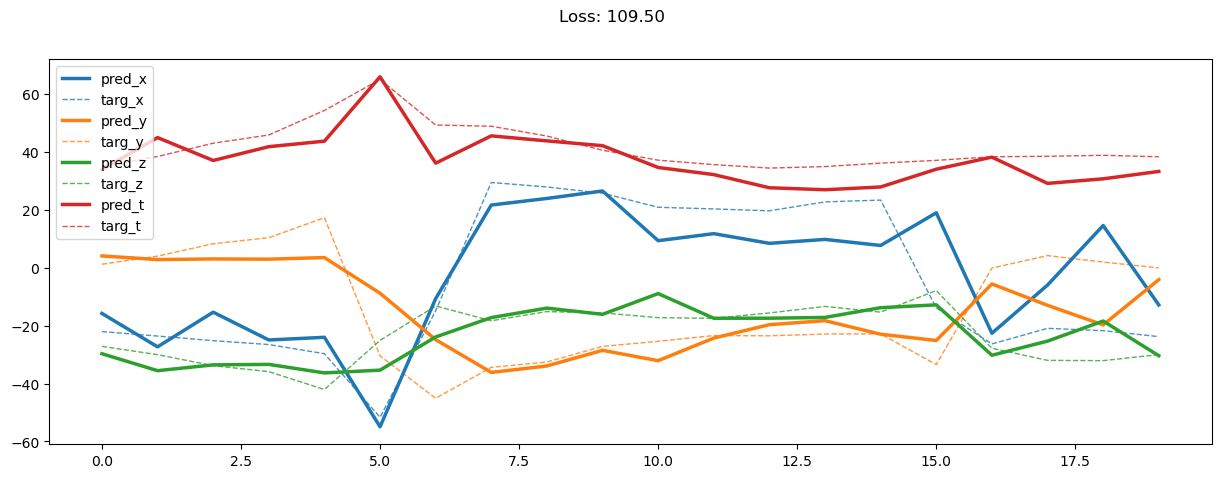

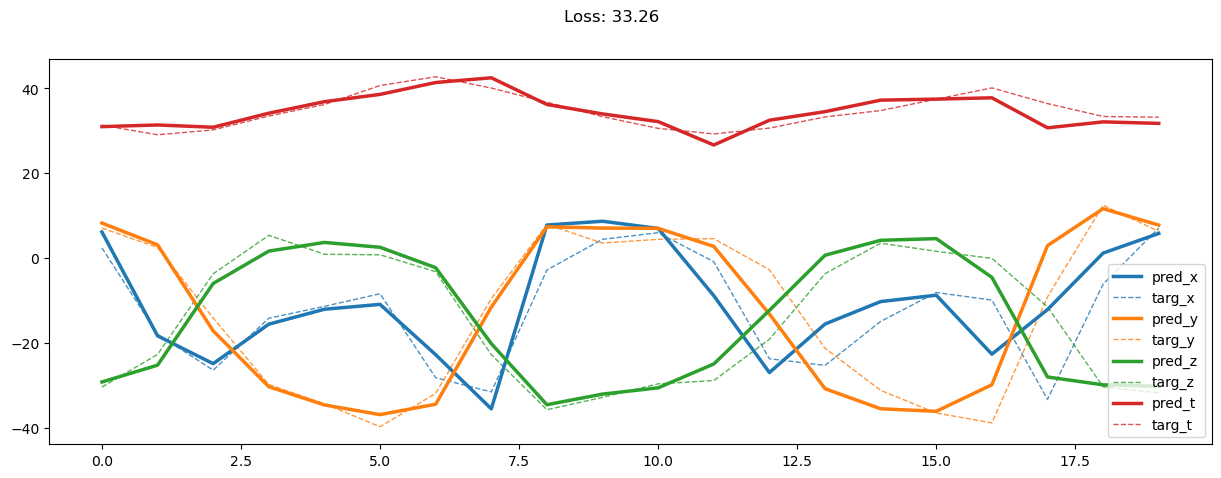

05000: train loss:  156.260, imu loss:  0.271, mag loss:  50.617, div loss:  101.060, slim:  5.590, tlim:  3.886
       valid loss:  796.191, imu loss:  0.535, mag loss:  386.285, div loss:  402.522, slim:  6.829, tlim:  6.857
05500: train loss:  139.100, imu loss:  0.270, mag loss:  45.179, div loss:  89.494, slim:  5.495, tlim:  3.711
       valid loss:  795.070, imu loss:  0.536, mag loss:  387.848, div loss:  400.039, slim:  6.636, tlim:  6.651


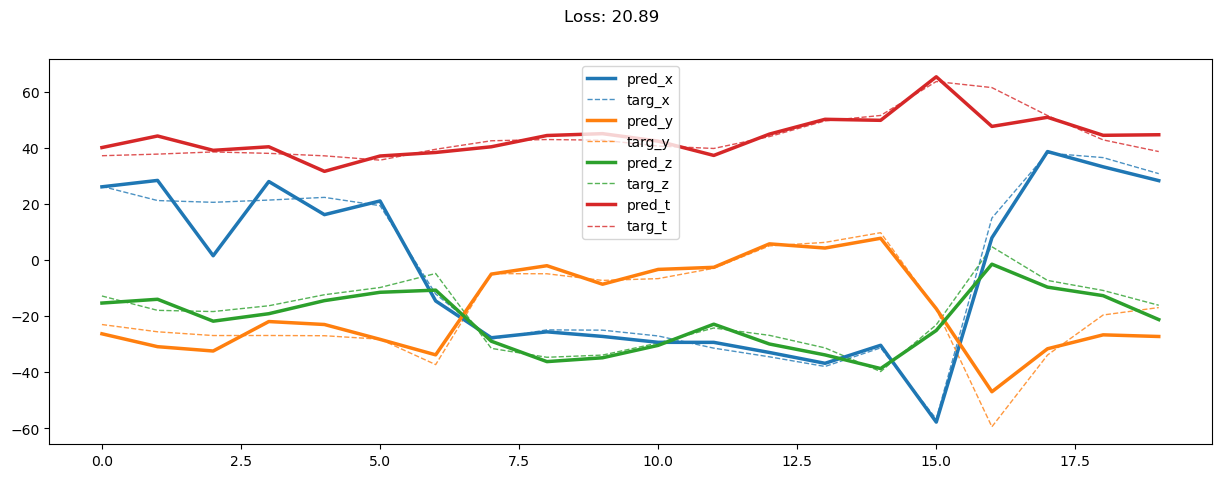

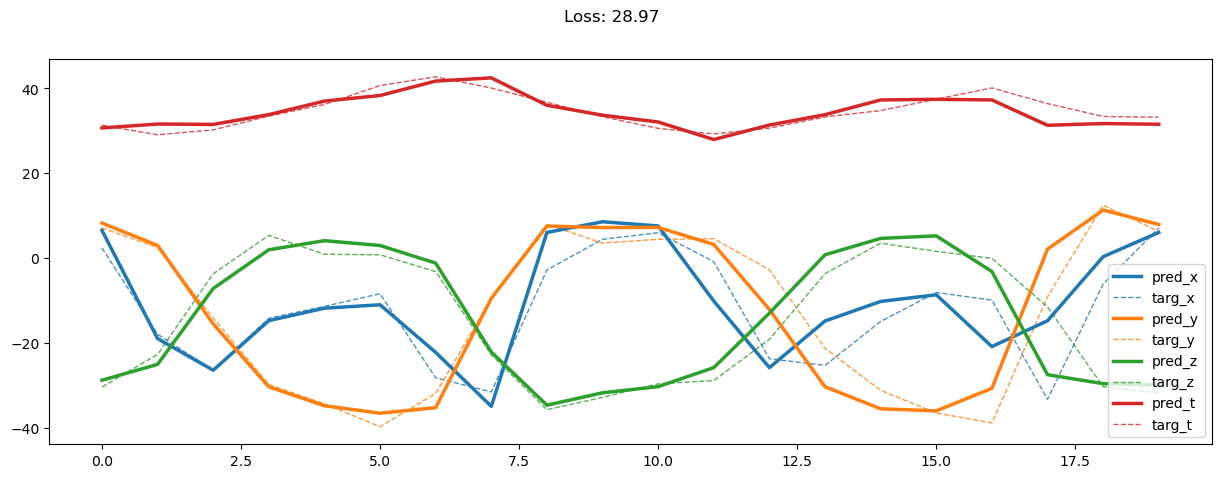

06000: train loss:  135.359, imu loss:  0.269, mag loss:  43.934, div loss:  87.132, slim:  5.436, tlim:  3.553
       valid loss:  790.917, imu loss:  0.536, mag loss:  386.329, div loss:  397.359, slim:  6.678, tlim:  6.698
06500: train loss:  121.391, imu loss:  0.268, mag loss:  39.515, div loss:  77.693, slim:  5.359, tlim:  3.433
       valid loss:  787.528, imu loss:  0.533, mag loss:  384.910, div loss:  395.643, slim:  6.533, tlim:  6.411


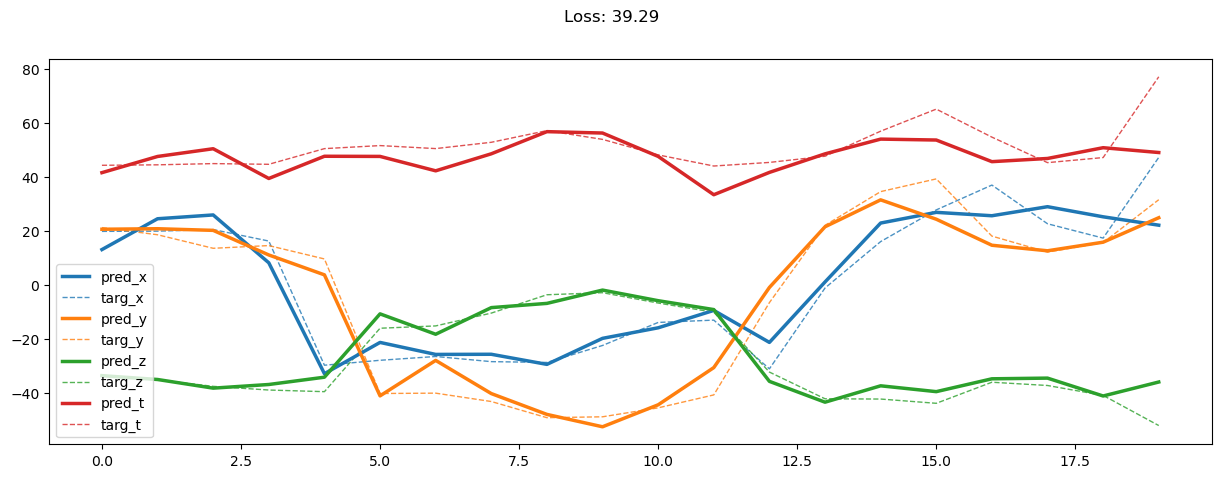

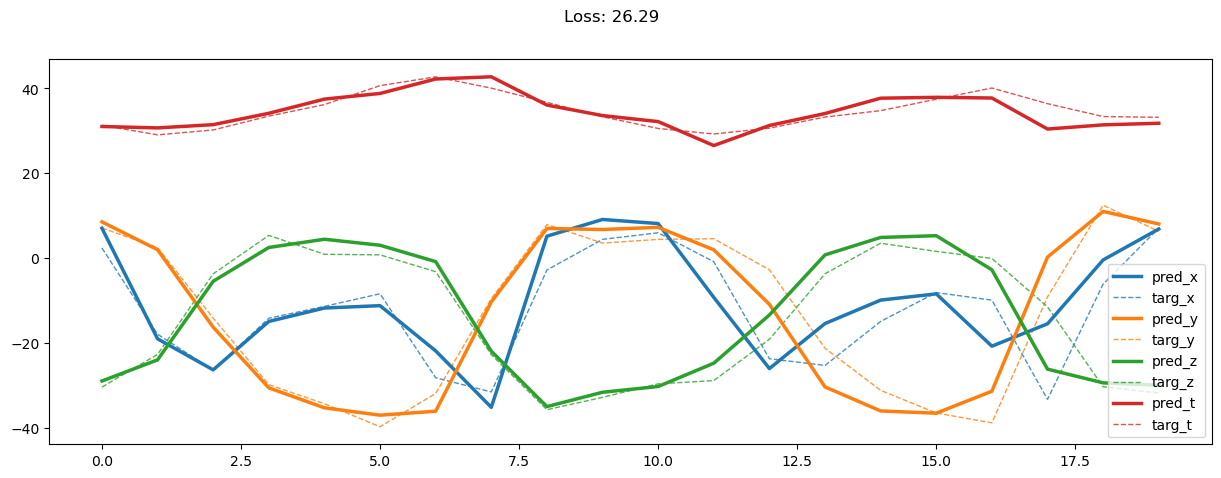

07000: train loss:  115.047, imu loss:  0.267, mag loss:  37.073, div loss:  73.811, slim:  5.308, tlim:  3.427
       valid loss:  780.768, imu loss:  0.533, mag loss:  381.434, div loss:  392.324, slim:  6.600, tlim:  6.435
07500: train loss:  113.965, imu loss:  0.266, mag loss:  36.666, div loss:  73.220, slim:  5.261, tlim:  3.331
       valid loss:  779.772, imu loss:  0.533, mag loss:  379.685, div loss:  393.005, slim:  6.736, tlim:  6.486


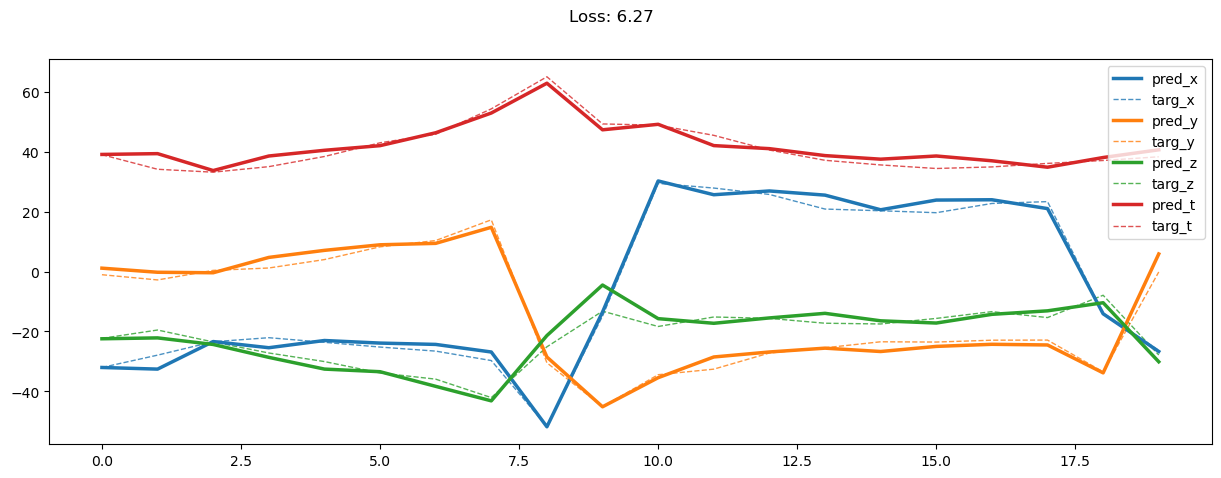

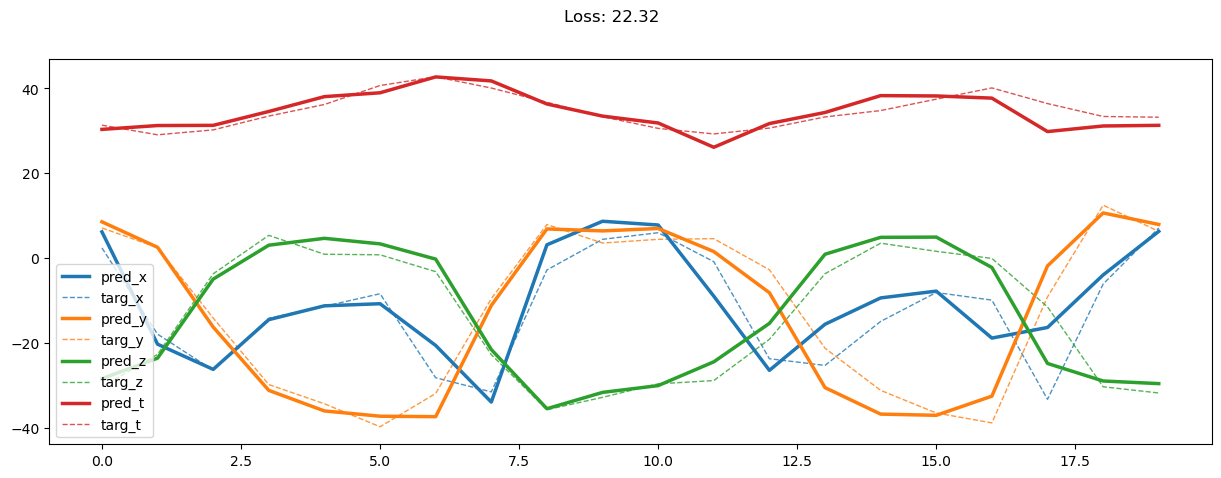

08000: train loss:  106.414, imu loss:  0.265, mag loss:  34.494, div loss:  67.997, slim:  5.171, tlim:  3.155
       valid loss:  787.863, imu loss:  0.534, mag loss:  385.710, div loss:  395.288, slim:  6.599, tlim:  6.242
08500: train loss:  98.939, imu loss:  0.264, mag loss:  31.800, div loss:  63.283, slim:  5.110, tlim:  3.085
       valid loss:  780.445, imu loss:  0.536, mag loss:  377.306, div loss:  396.090, slim:  6.789, tlim:  6.422


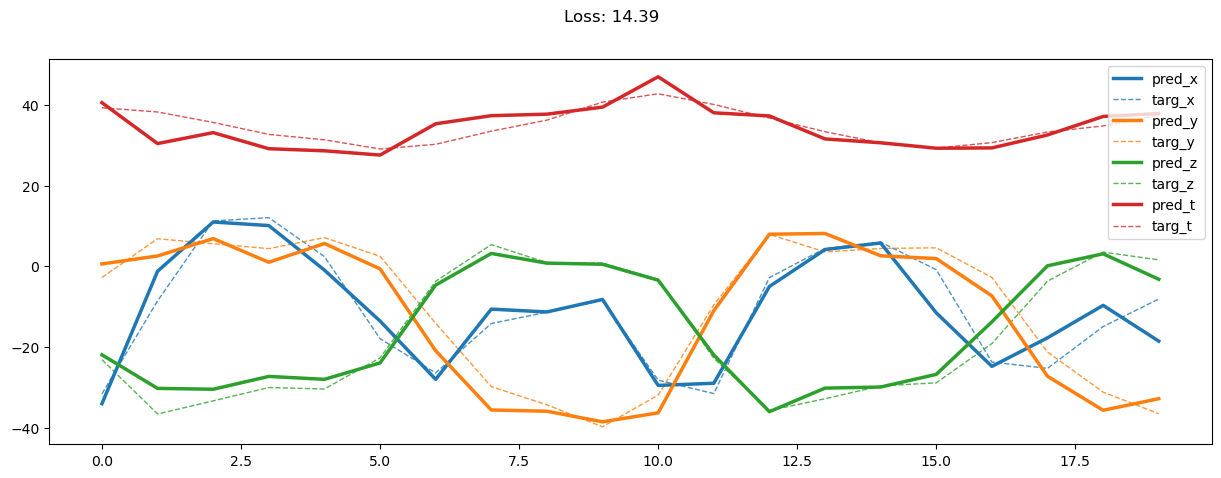

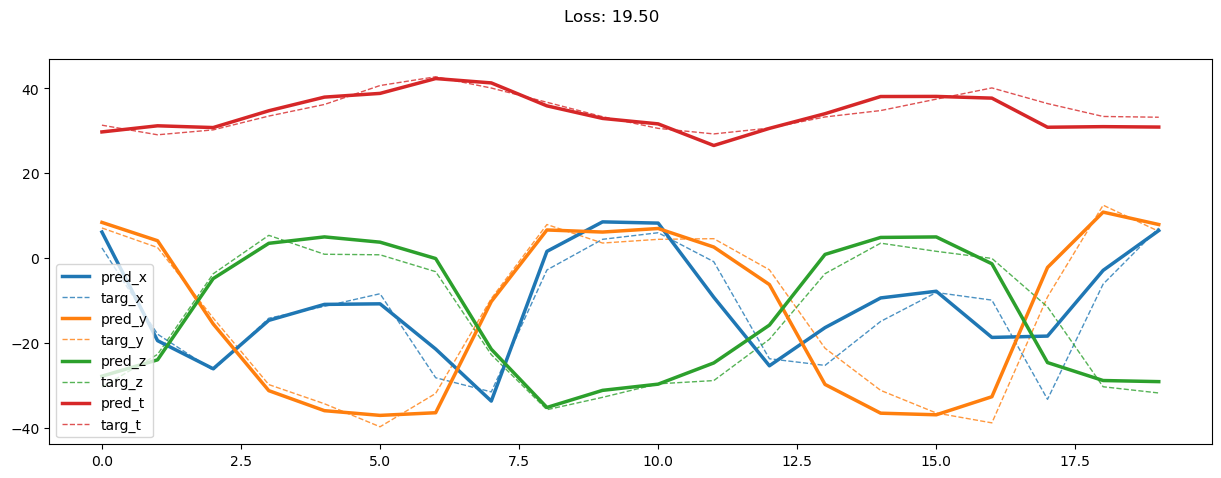

09000: train loss:  94.636, imu loss:  0.263, mag loss:  29.871, div loss:  60.956, slim:  5.075, tlim:  3.036
       valid loss:  784.237, imu loss:  0.534, mag loss:  382.158, div loss:  394.965, slim:  6.865, tlim:  6.486
09500: train loss:  87.543, imu loss:  0.263, mag loss:  28.503, div loss:  55.319, slim:  5.034, tlim:  2.934
       valid loss:  774.896, imu loss:  0.531, mag loss:  374.415, div loss:  393.412, slim:  6.867, tlim:  6.429


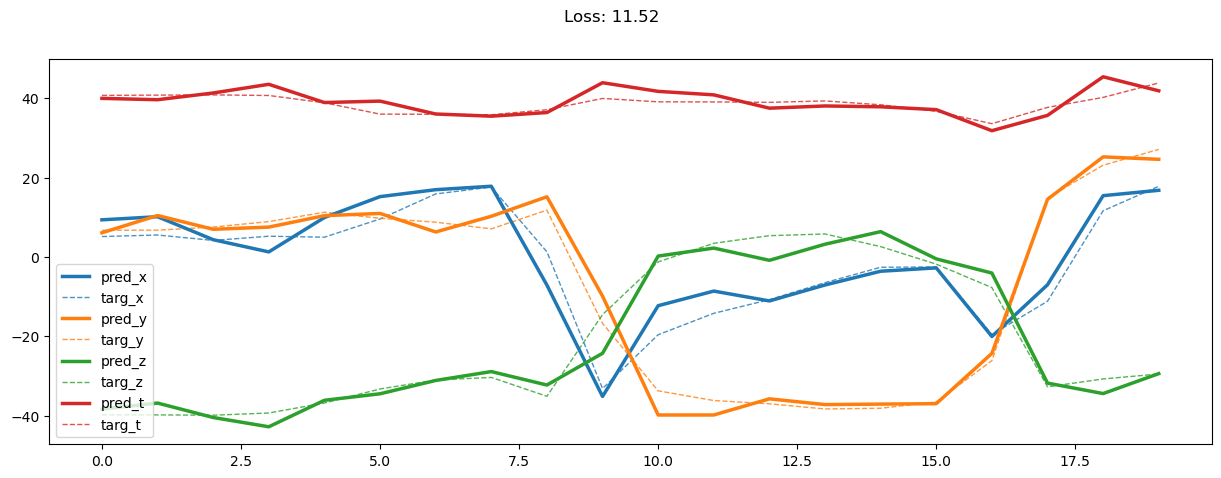

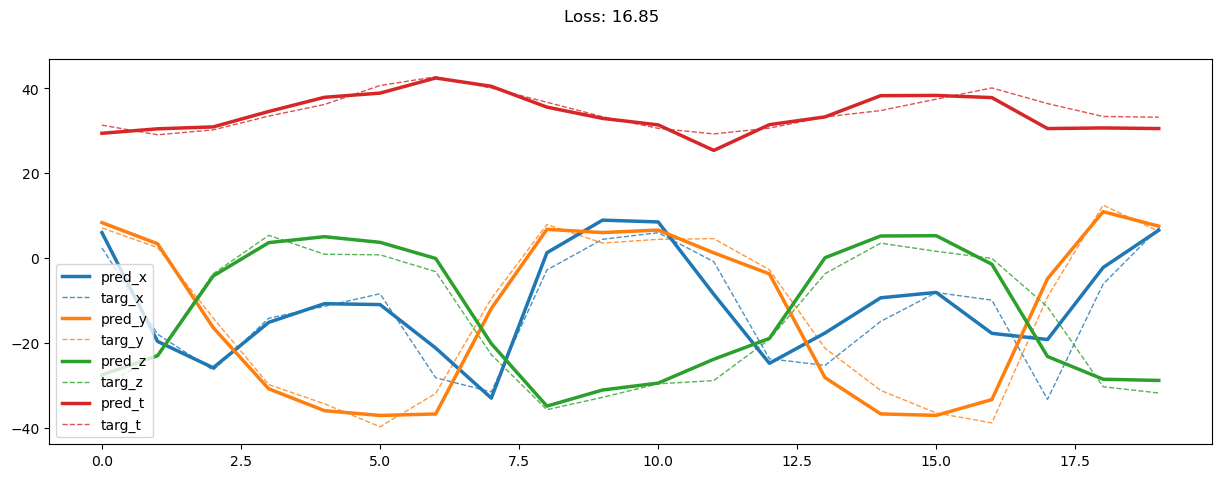

10000: train loss:  87.592, imu loss:  0.262, mag loss:  28.114, div loss:  55.783, slim:  5.048, tlim:  2.895
       valid loss:  787.494, imu loss:  0.530, mag loss:  383.670, div loss:  396.902, slim:  6.690, tlim:  6.292
10500: train loss:  85.084, imu loss:  0.261, mag loss:  27.029, div loss:  54.429, slim:  5.012, tlim:  2.815
       valid loss:  787.713, imu loss:  0.531, mag loss:  380.005, div loss:  400.861, slim:  6.615, tlim:  6.216


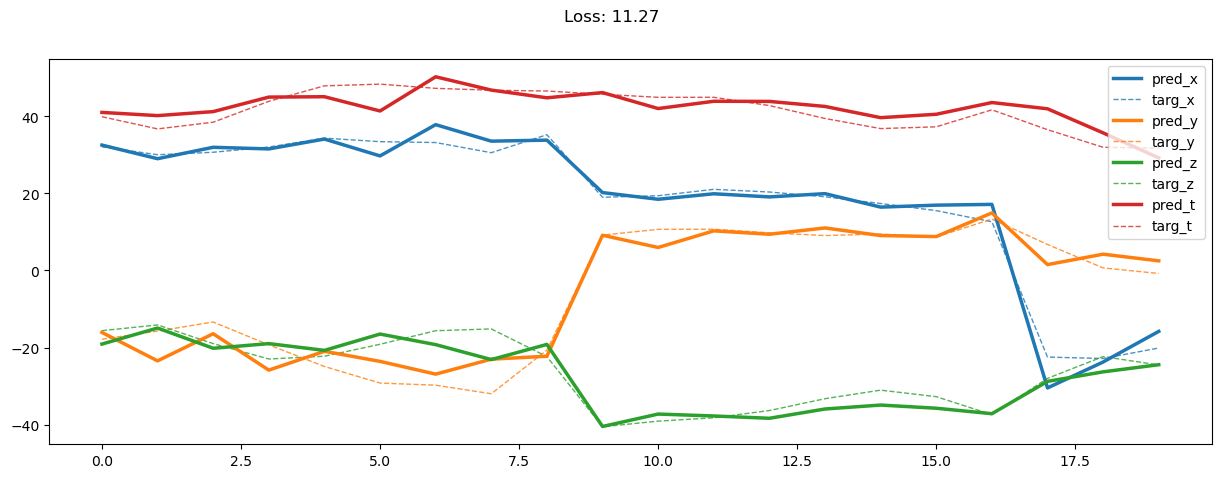

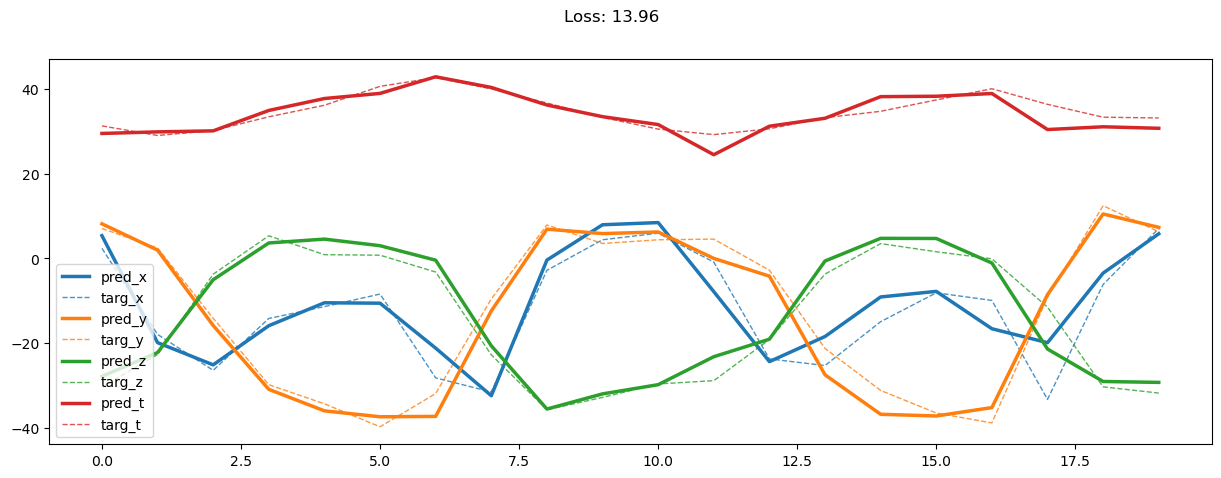

11000: train loss:  81.760, imu loss:  0.260, mag loss:  26.155, div loss:  52.030, slim:  4.953, tlim:  2.769
       valid loss:  784.437, imu loss:  0.529, mag loss:  378.965, div loss:  398.693, slim:  6.534, tlim:  6.156
11500: train loss:  75.269, imu loss:  0.259, mag loss:  24.111, div loss:  47.642, slim:  4.934, tlim:  2.697
       valid loss:  791.076, imu loss:  0.529, mag loss:  382.267, div loss:  402.176, slim:  6.383, tlim:  6.011


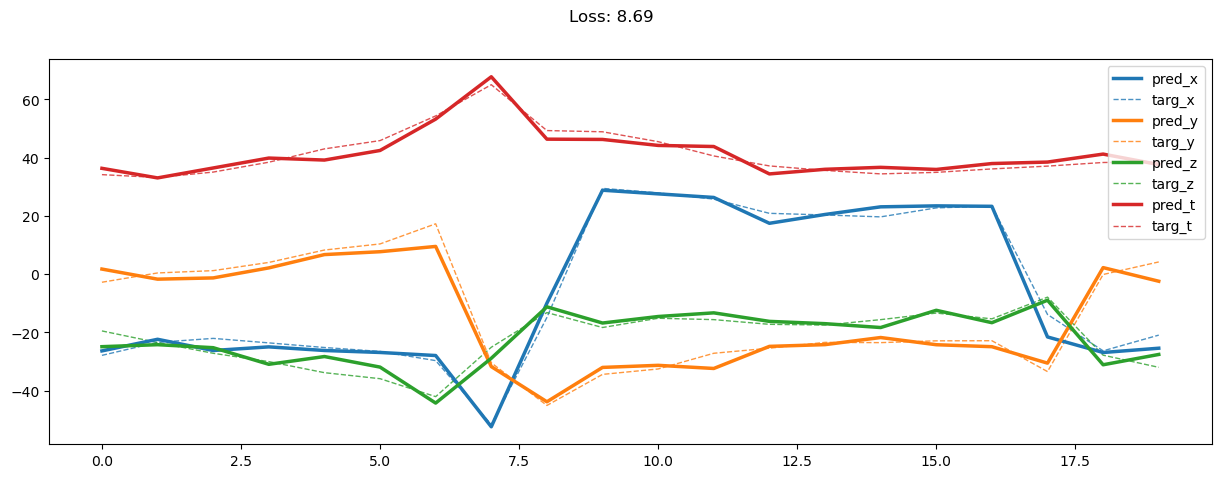

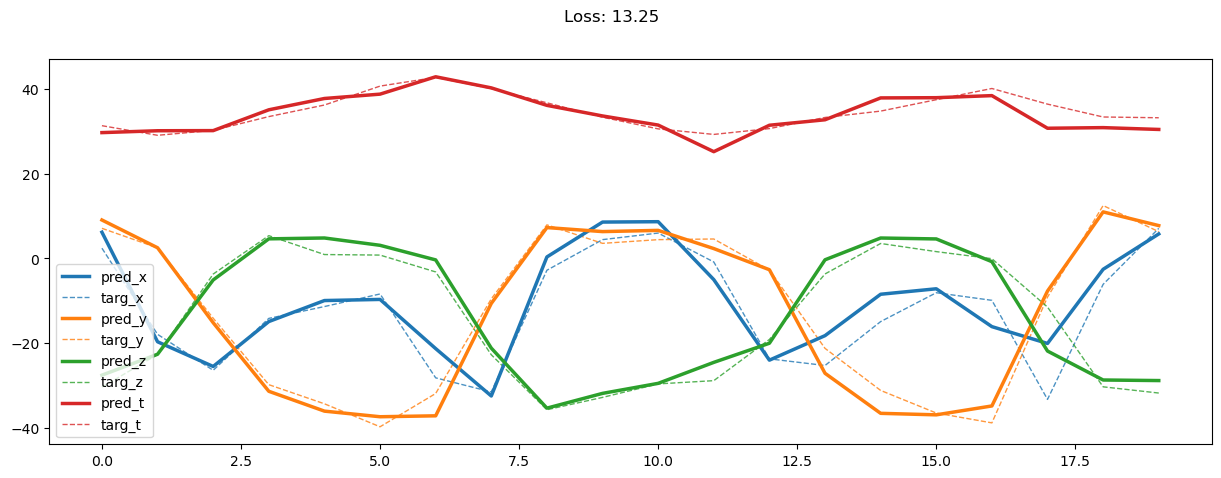

12000: train loss:  76.994, imu loss:  0.258, mag loss:  24.360, div loss:  49.128, slim:  4.855, tlim:  2.711
       valid loss:  778.739, imu loss:  0.528, mag loss:  375.936, div loss:  395.916, slim:  6.615, tlim:  6.273
12500: train loss:  72.049, imu loss:  0.256, mag loss:  23.057, div loss:  45.550, slim:  4.864, tlim:  2.627
       valid loss:  772.465, imu loss:  0.528, mag loss:  372.781, div loss:  393.020, slim:  6.429, tlim:  6.037


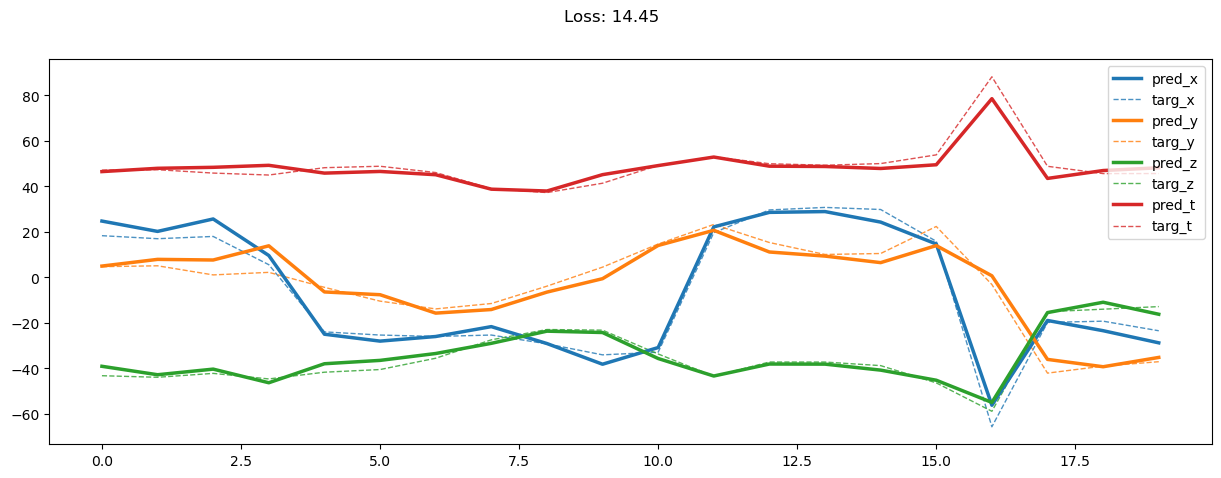

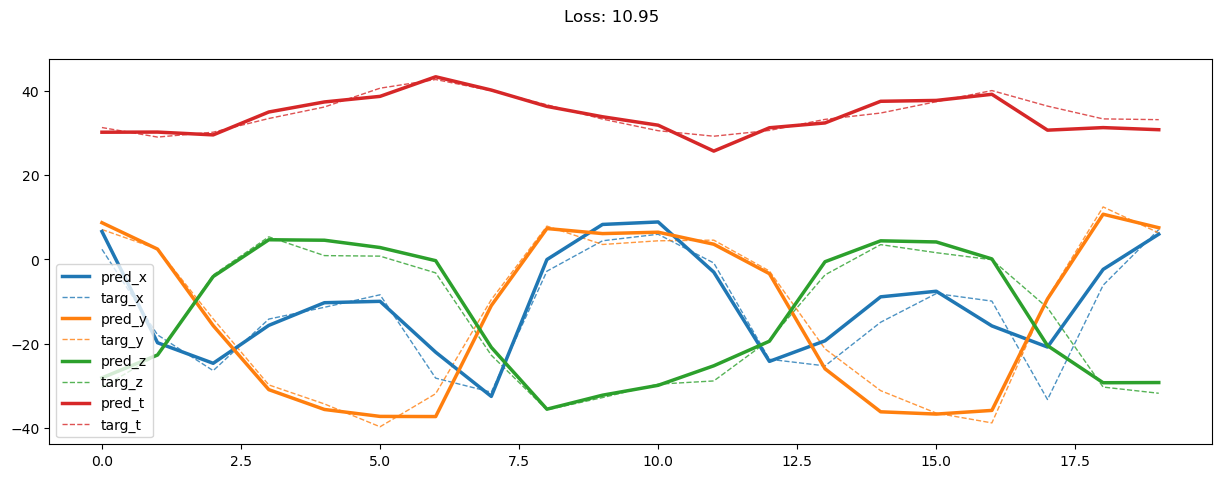

13000: train loss:  69.270, imu loss:  0.257, mag loss:  21.967, div loss:  43.915, slim:  4.866, tlim:  2.553
       valid loss:  768.035, imu loss:  0.530, mag loss:  366.482, div loss:  394.917, slim:  6.375, tlim:  6.016
13500: train loss:  67.877, imu loss:  0.256, mag loss:  21.592, div loss:  42.946, slim:  4.810, tlim:  2.508
       valid loss:  773.316, imu loss:  0.530, mag loss:  370.909, div loss:  395.792, slim:  6.327, tlim:  6.003


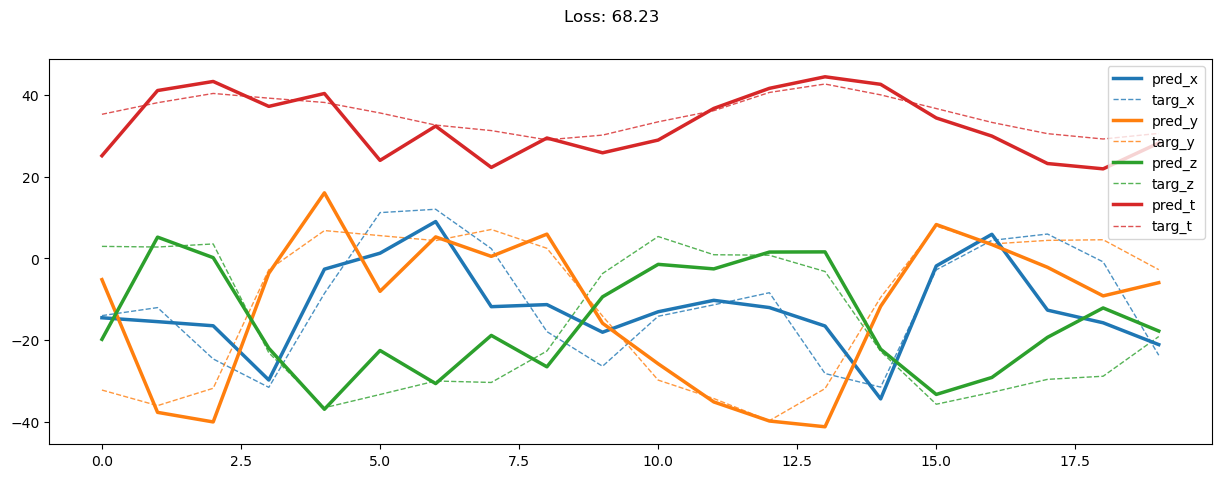

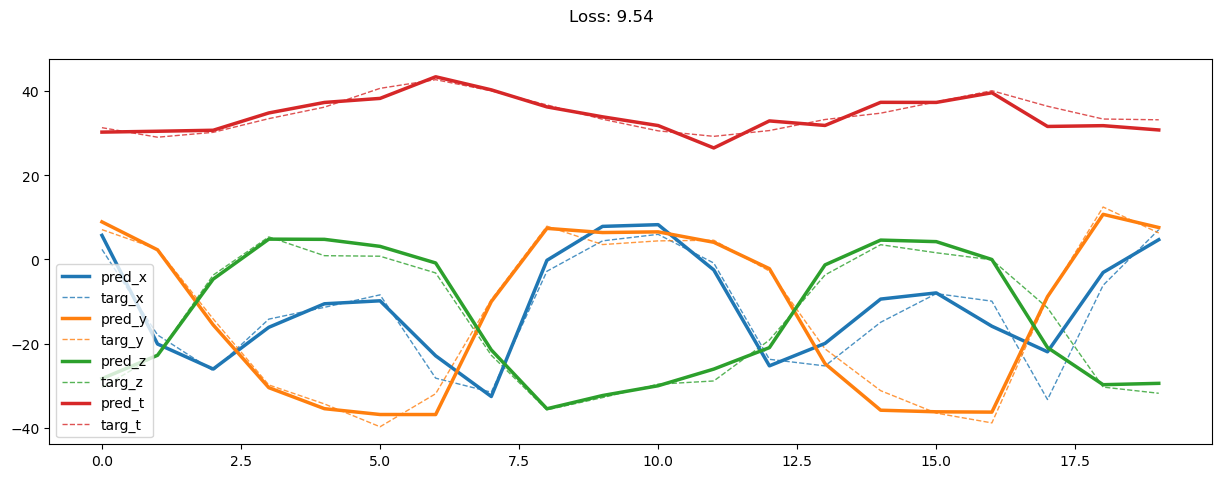

14000: train loss:  63.198, imu loss:  0.255, mag loss:  20.010, div loss:  39.827, slim:  4.819, tlim:  2.535
       valid loss:  774.048, imu loss:  0.530, mag loss:  369.956, div loss:  397.483, slim:  6.356, tlim:  5.987
14500: train loss:  61.642, imu loss:  0.254, mag loss:  19.630, div loss:  38.721, slim:  4.793, tlim:  2.452
       valid loss:  772.692, imu loss:  0.530, mag loss:  372.379, div loss:  393.765, slim:  6.235, tlim:  5.945


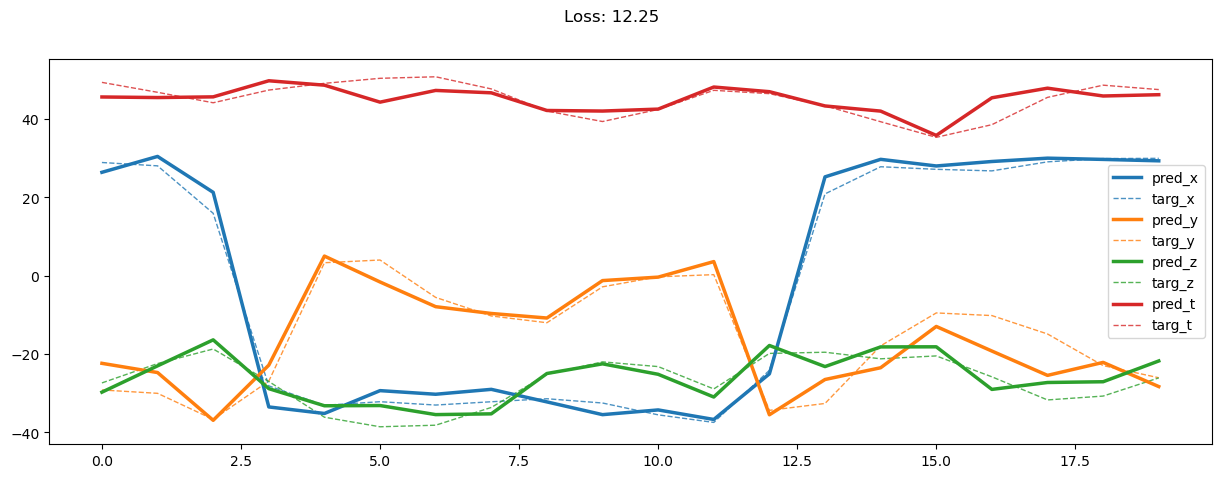

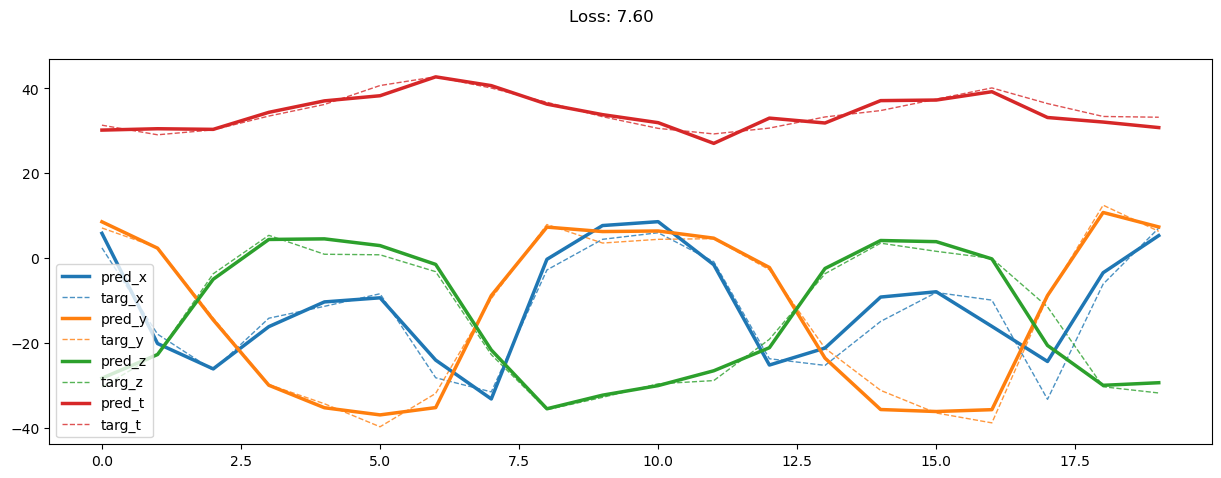

15000: train loss:  60.263, imu loss:  0.254, mag loss:  19.298, div loss:  37.702, slim:  4.771, tlim:  2.422
       valid loss:  791.210, imu loss:  0.532, mag loss:  376.918, div loss:  407.770, slim:  6.211, tlim:  5.916
15500: train loss:  60.454, imu loss:  0.252, mag loss:  19.051, div loss:  38.153, slim:  4.770, tlim:  2.406
       valid loss:  790.815, imu loss:  0.531, mag loss:  377.315, div loss:  406.802, slim:  6.377, tlim:  6.097


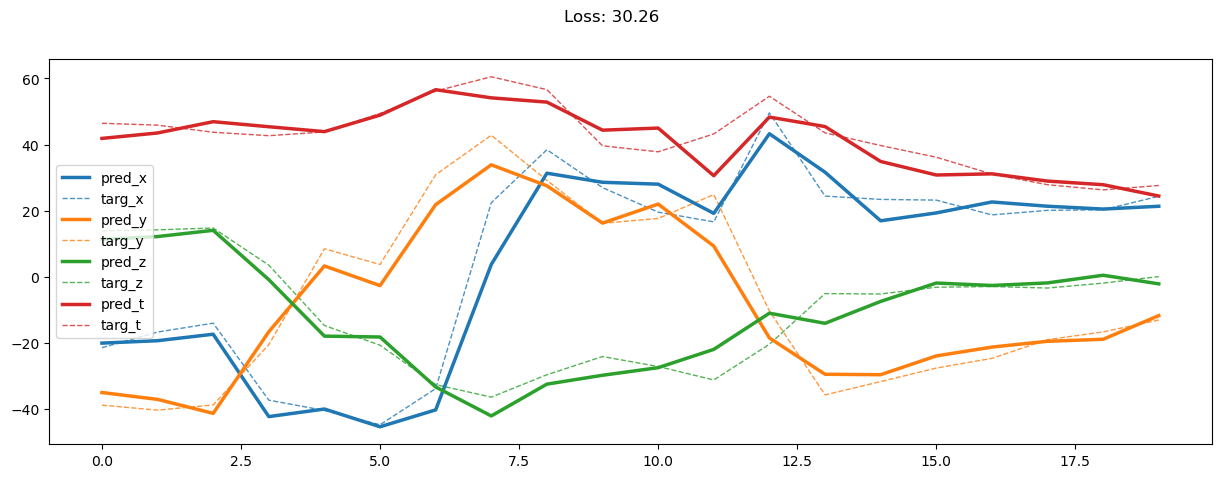

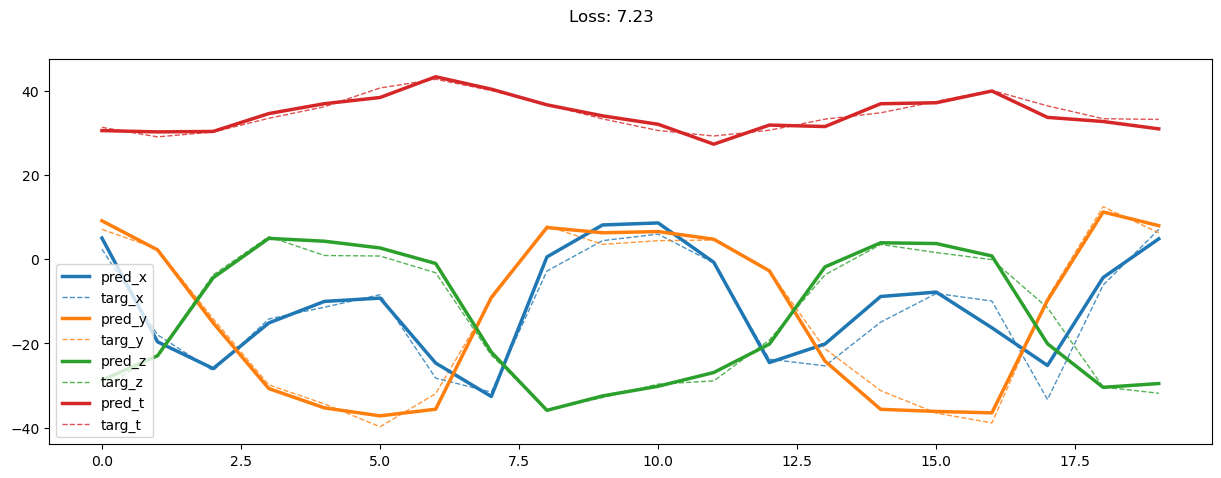

16000: train loss:  55.647, imu loss:  0.252, mag loss:  17.461, div loss:  35.009, slim:  4.691, tlim:  2.337
       valid loss:  787.650, imu loss:  0.528, mag loss:  374.811, div loss:  406.274, slim:  6.207, tlim:  5.981
16500: train loss:  56.122, imu loss:  0.252, mag loss:  17.737, div loss:  35.228, slim:  4.711, tlim:  2.304
       valid loss:  790.611, imu loss:  0.532, mag loss:  377.580, div loss:  406.518, slim:  6.191, tlim:  5.911


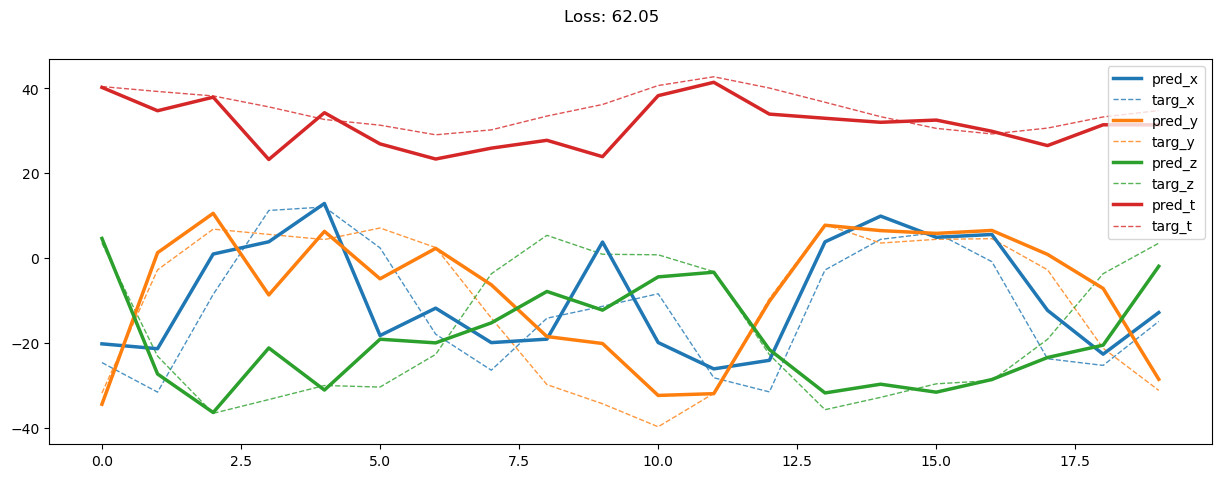

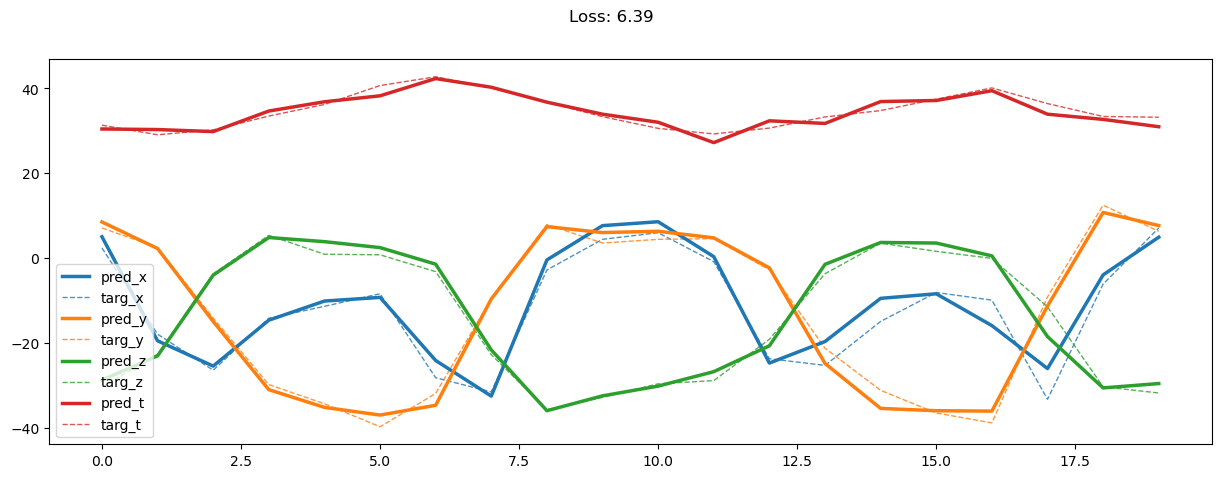

17000: train loss:  52.384, imu loss:  0.251, mag loss:  16.423, div loss:  32.823, slim:  4.666, tlim:  2.294
       valid loss:  760.653, imu loss:  0.534, mag loss:  363.510, div loss:  390.438, slim:  6.326, tlim:  6.120
17500: train loss:  56.594, imu loss:  0.251, mag loss:  17.859, div loss:  35.628, slim:  4.710, tlim:  2.238
       valid loss:  779.630, imu loss:  0.533, mag loss:  371.721, div loss:  401.264, slim:  6.323, tlim:  6.041


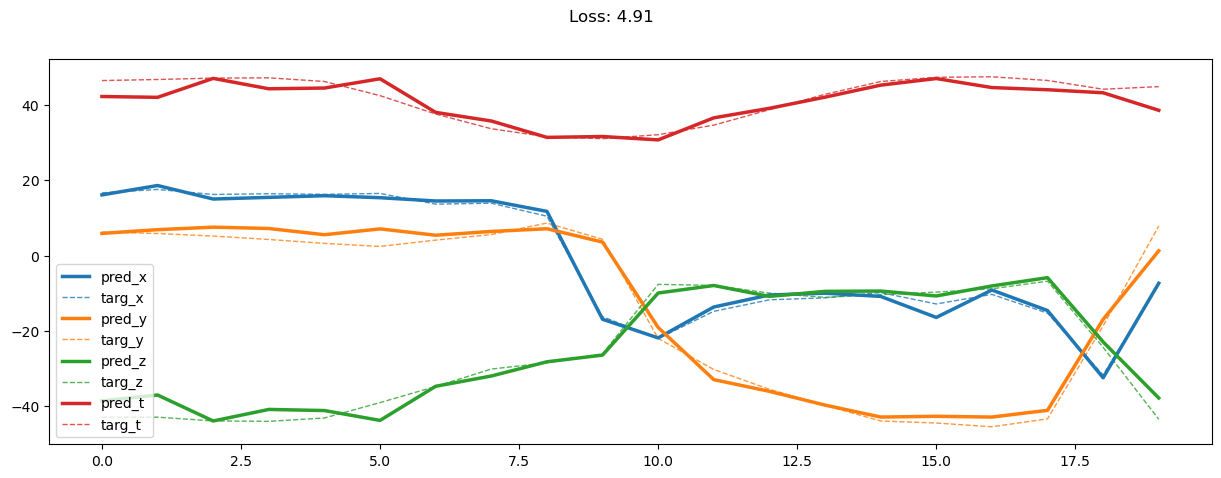

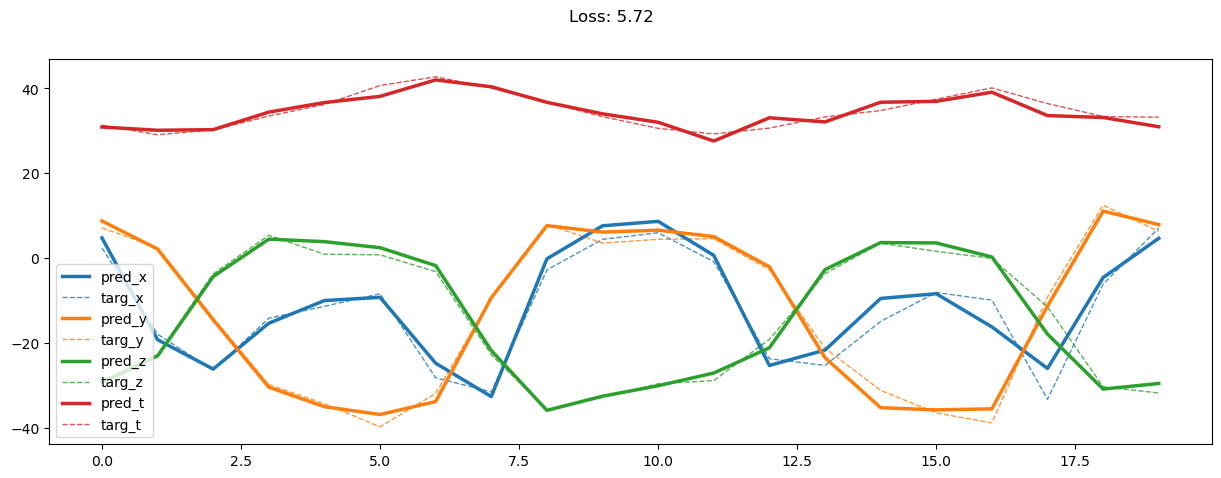

18000: train loss:  53.080, imu loss:  0.250, mag loss:  16.576, div loss:  33.414, slim:  4.694, tlim:  2.221
       valid loss:  791.620, imu loss:  0.534, mag loss:  376.240, div loss:  408.771, slim:  6.211, tlim:  6.030
18500: train loss:  50.297, imu loss:  0.250, mag loss:  15.746, div loss:  31.495, slim:  4.626, tlim:  2.199
       valid loss:  783.807, imu loss:  0.536, mag loss:  373.332, div loss:  403.657, slim:  6.433, tlim:  6.231


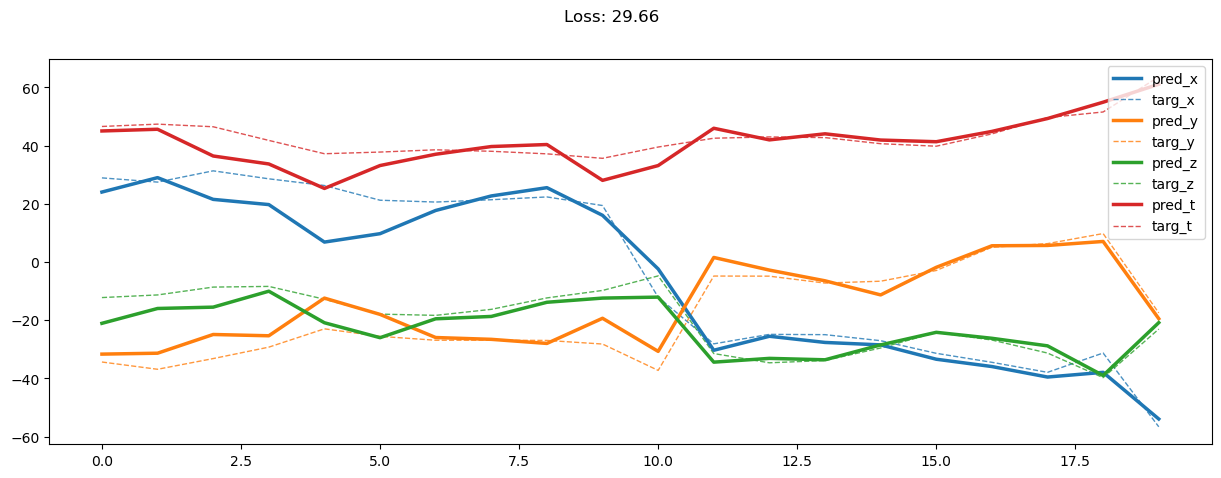

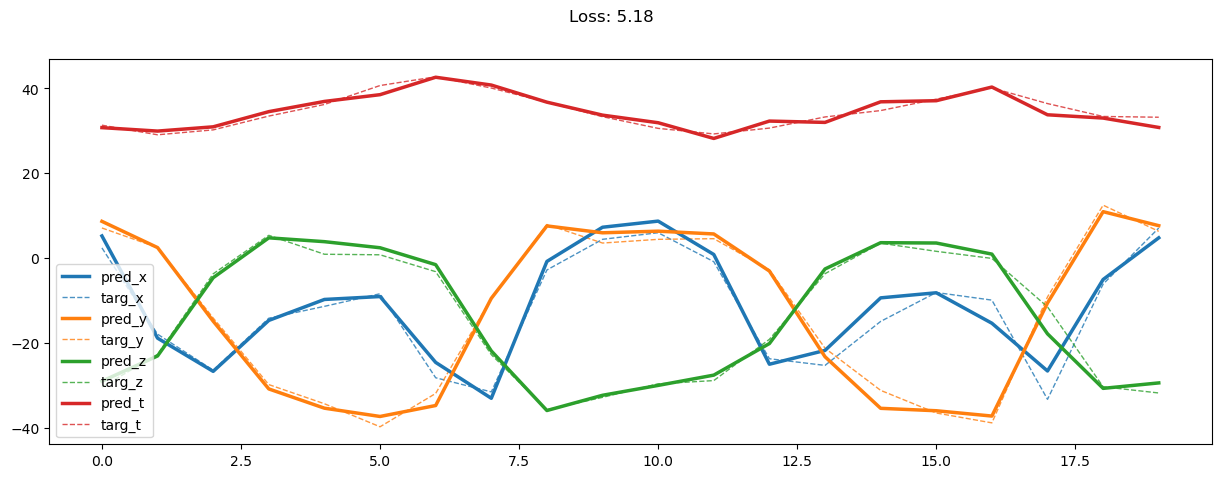

19000: train loss:  51.930, imu loss:  0.250, mag loss:  16.354, div loss:  32.471, slim:  4.701, tlim:  2.239
       valid loss:  766.086, imu loss:  0.534, mag loss:  366.895, div loss:  392.402, slim:  6.416, tlim:  6.201
19500: train loss:  48.711, imu loss:  0.248, mag loss:  15.382, div loss:  30.300, slim:  4.616, tlim:  2.169
       valid loss:  791.951, imu loss:  0.536, mag loss:  375.268, div loss:  409.888, slim:  6.401, tlim:  6.212


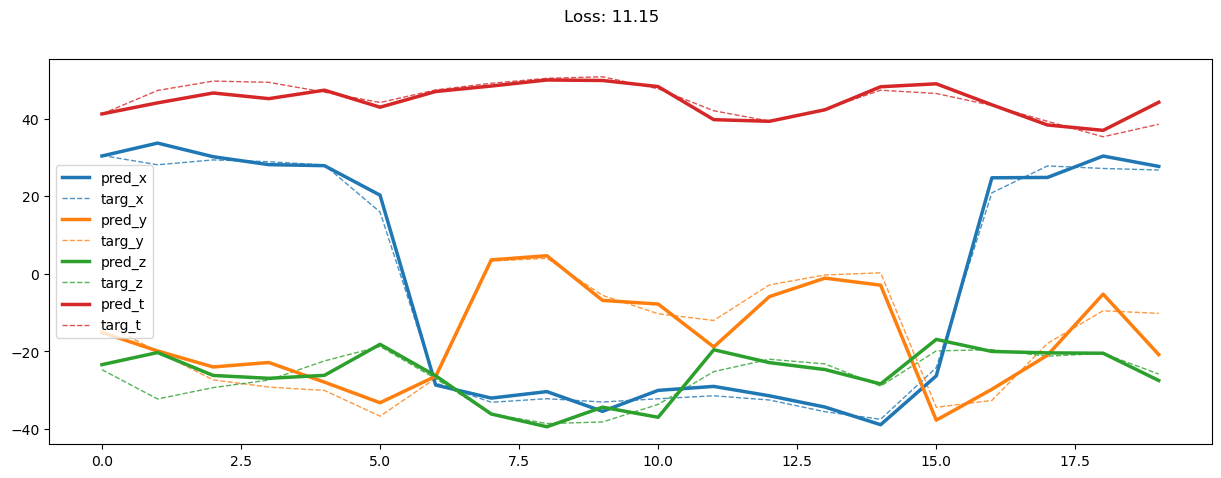

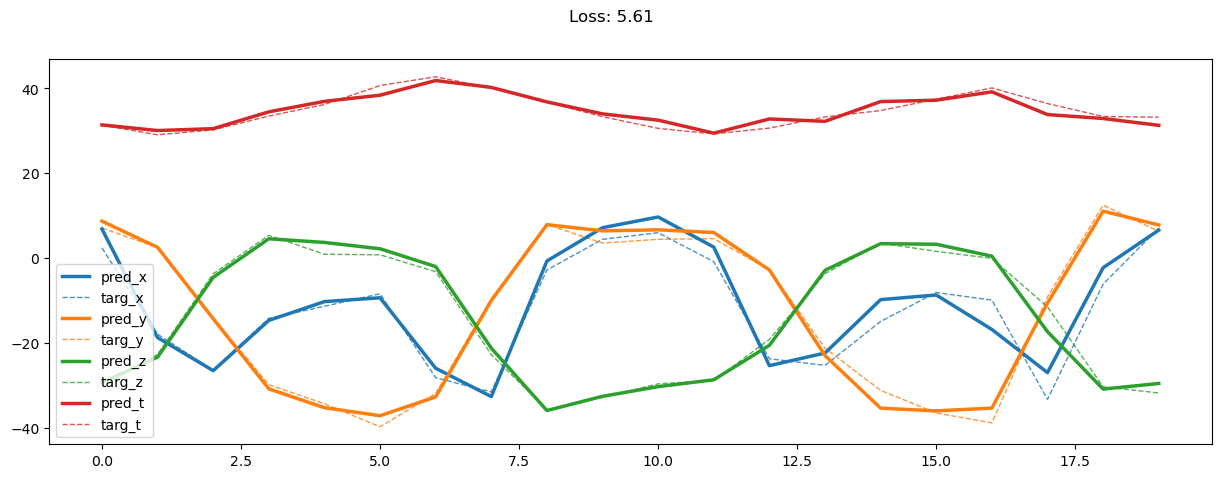

20000: train loss:  51.825, imu loss:  0.248, mag loss:  16.312, div loss:  32.504, slim:  4.611, tlim:  2.144
       valid loss:  813.249, imu loss:  0.534, mag loss:  382.359, div loss:  424.314, slim:  6.159, tlim:  6.001


In [26]:
EPOCH = 20000
draw = True

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 1000 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 500 == 0:
        ep = str(epoch + 1).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}, div loss: {t_d1_loss: 2.3f}, slim: {tlim_loss[0]: 2.3f}, tlim: {tlim_loss[1]: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}, div loss: {v_d1_loss: 2.3f}, slim: {vlim_loss[0]: 2.3f}, tlim: {vlim_loss[1]: 2.3f}')

In [31]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 2:8]
            source_mag = source_data[:, :, 8:11]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 2:8]
            target_mag = target_data[:, :, 8:11]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_pos = target_pos.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label, target_pos))
            
            diff = np.absolute(predict_mag.reshape(len(predict_mag), -1, 3) - target_mag.reshape(len(target_mag), -1, 3)).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [28]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(440, 4) (440, 3) (440,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     1.42     1.52     1.29     1.41
     horizontal loss:     2.19     2.09     1.56     1.95
         pocket loss:     1.42     1.59     1.45     1.49
          swing loss:     1.19     1.29     1.12     1.20
        average loss:     1.56     1.62     1.36     1.51


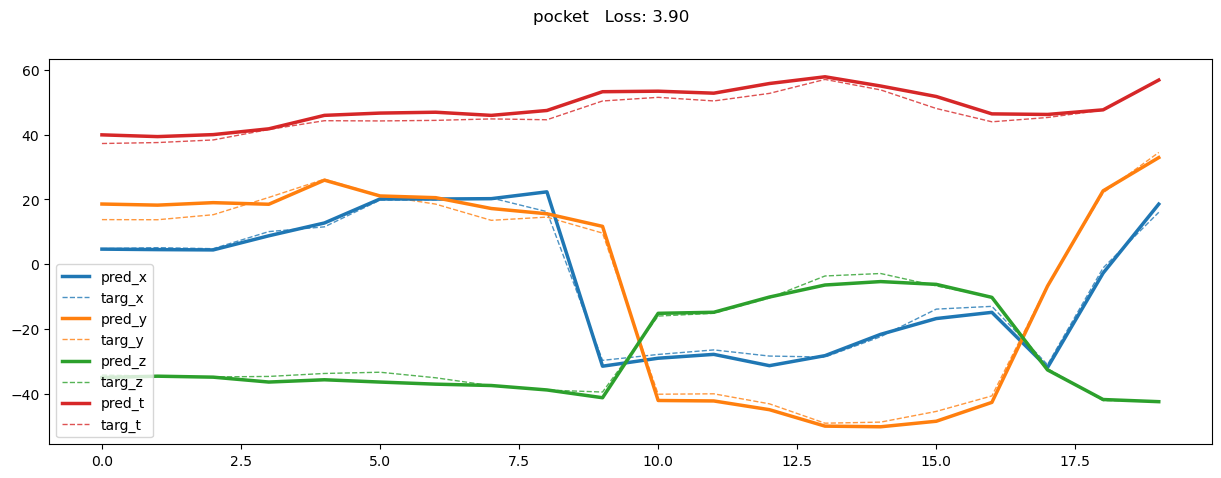

In [32]:
results, cres, clabel = output_eval(model, train_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::500]:
    plot_result(rs)

(52, 4) (52, 3) (52,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    11.83    12.72    14.91    13.15
     horizontal loss:    14.11    20.81    19.73    18.22
         pocket loss:    15.10    16.99    15.99    16.03
          swing loss:     9.75    11.41    10.60    10.58
        average loss:    12.70    15.48    15.31    14.50


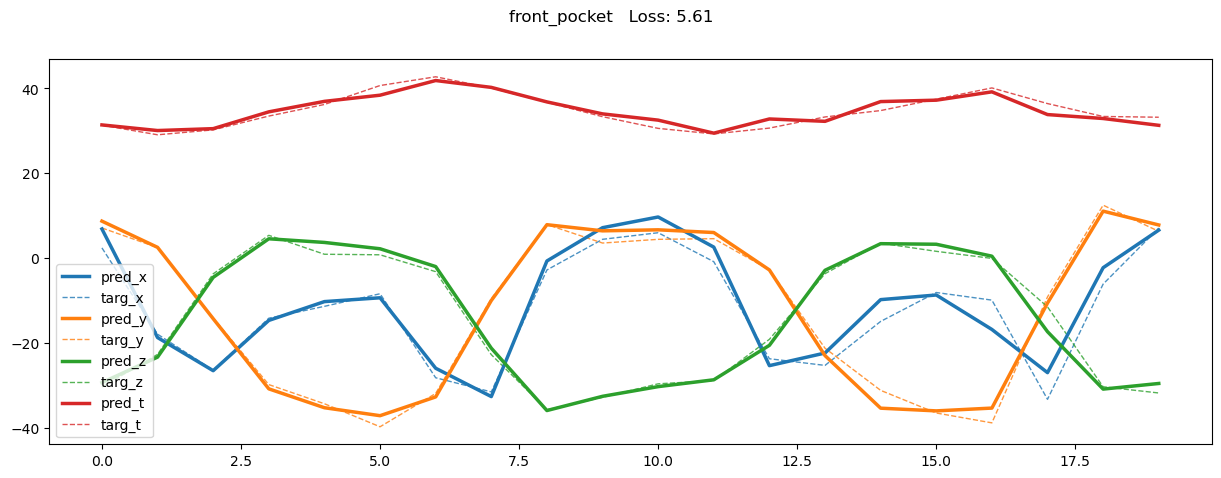

In [33]:
results, cres, clabel = output_eval(model, valid_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::100]:
    plot_result(rs)

In [ ]:
# classes = {0: 'target', 1: 'front_pocket', 2: 'horizontal', 3: 'pocket', 4: 'swing'}

In [ ]:
pred_results = {}

get_posture = lambda x, y: np.concatenate((list(results[results[:, 2] == y, 3]), list(results[results[:, 2] == y, 0])), axis=-1)

pred_results['target'] = prep_valid_target_traj[:, :, [0, 1, 8, 9, 10]]
pred_results['front_pocket'] = get_posture(results, 1)
pred_results['horizontal'] = get_posture(results, 2)
pred_results['pocket'] = get_posture(results, 3)
pred_results['swing'] = get_posture(results, 4)

In [ ]:
pred_results['target'].shape, pred_results['front_pocket'].shape, pred_results['horizontal'].shape, pred_results['pocket'].shape, pred_results['swing'].shape

In [ ]:
np.save(f'./pred_results.npy', pred_results)

In [ ]:
def plot_eval_result(result, path):
    pred_mag = np.stack(results[:, 0], axis=0)[:, 0].reshape(-1, 3)
    targ_mag = np.stack(results[:, 1], axis=0)[:, 0].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(25, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{path}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [ ]:
def load_data(name):
    return posture_data[name], posture_data['target']

def split_data(df):
    ncols = seq_len
    nrows = len(df) - seq_len + 1
    
    index = np.zeros((nrows, ncols), dtype=int)
    index += np.arange(ncols)
    index += np.arange(nrows).T[:, None]
    
    return df.to_numpy()[index]    

def combine_to_dataloader(source, target):
    dataset = PairDataset(
                        source_data = torch.tensor(source, dtype=torch.float),
                        source_label = np.zeros(len(source)),
                        target_data = torch.tensor(target, dtype=torch.float),
                        target_label = np.zeros(len(target)),
                    )
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False)
    
    return dataloader

def generate_dataloader(name):
    source_df, target_df = load_data(name)
    source_segs, target_segs = split_data(source_df), split_data(target_df)

    return combine_to_dataloader(source_segs, target_segs)

In [ ]:
for folder in ['./front_pocket/*', './pocket/*', './swing/*']:
    for path in glob.glob(folder):
        eval_loader = generate_dataloader(name)
        results, _, _ = output_eval(model, eval_loader)
        plot_eval_result(results, path)

In [ ]:
print(1)

In [ ]:
torch.save(model, 'transformer.pt')

In [ ]:
model = torch.load('/root/Calibration/R403/transformer.pt')

In [ ]:
results, cres, clabel = output_eval(model, train_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::500]:
    plot_result(rs)

In [ ]:
results, cres, clabel = output_eval(model, valid_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::100]:
    plot_result(rs)